In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torchvision.models.segmentation.deeplabv3
from fastai import *

from fastai.vision import *
import os
import json

In [3]:
path_img = "/home/hanwei-1/data/seg/benign_voc/JPEGImages"
msak_img = "/home/hanwei-1/data/seg/benign_voc/bin_img"

def get_y_fn(x):
    pre, ext = os.path.splitext(x)
    pre = pre.replace('JPEGImages','bin_img')+".png"
#     print(pre)
    return pre

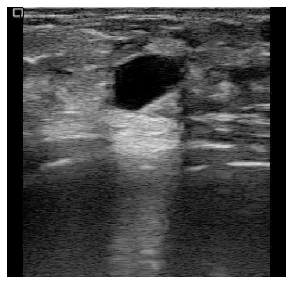

In [4]:
all_file = get_image_files(path_img)
img_f = all_file[1]
img = open_image(img_f)
img.show(figsize=(5, 5))

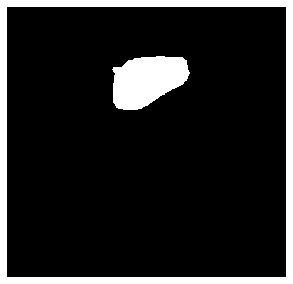

In [5]:
mask = open_image(get_y_fn(img_f))
mask.show(figsize=(5, 5))

In [6]:
class MySegmentationLabelList(SegmentationLabelList):
    def open(self, fn):
        return open_mask(fn, div=True)

class MySegmentationItemList(SegmentationItemList):
    _label_cls = MySegmentationLabelList

transforms = get_transforms(do_flip=False, max_zoom=5, max_warp=5,max_rotate=5, p_lighting=1)    
    
data = (MySegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=['0','1'])
        .transform(get_transforms(), tfm_y=True)
        .databunch(bs=8)
        .normalize(imagenet_stats))

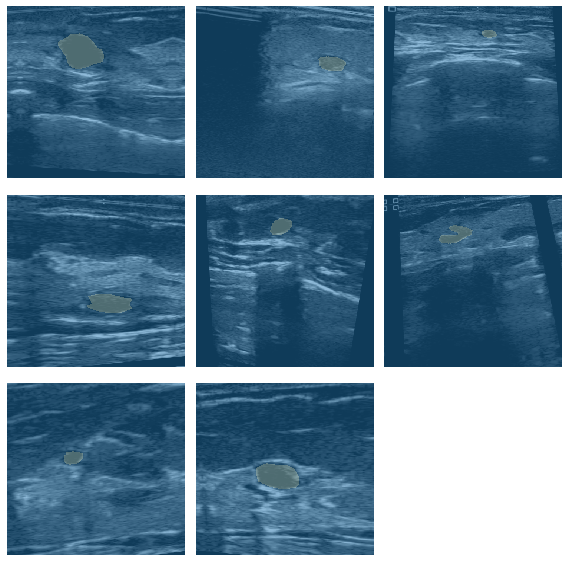

In [7]:
data.show_batch(3, figsize=(8, 8), alpha=0.5)

In [8]:
torch.cuda.set_device(0)
learn = unet_learner(data, models.resnet34,metrics=dice)

In [9]:
learn.fit_one_cycle(cyc_len = 30,max_lr = slice(1e-05, 1e-03))

epoch,train_loss,valid_loss,dice,time
0,0.143857,0.121639,0.000036,00:20
1,0.101041,0.076515,0.555447,00:12
2,0.085663,0.061360,0.644160,00:12
3,0.068965,0.048605,0.817211,00:12
4,0.057045,0.030537,0.829438,00:13
5,0.049737,0.040440,0.727088,00:13
6,0.045467,0.019323,0.872241,00:13
7,0.039178,0.031433,0.840678,00:13
8,0.033338,0.018319,0.880792,00:13
9,0.027616,0.040279,0.812238,00:13


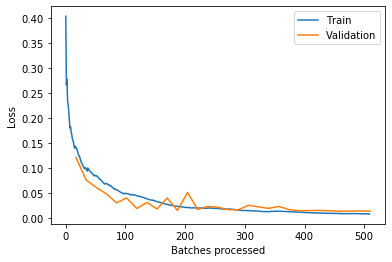

In [10]:
learn.recorder.plot_losses()

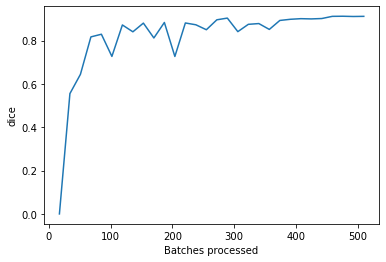

In [11]:
learn.recorder.plot_metrics()

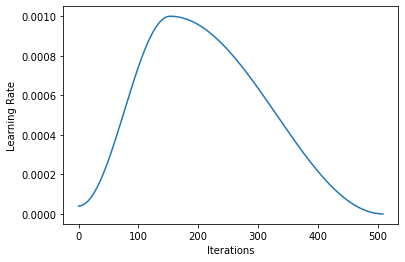

In [12]:
learn.recorder.plot_lr()

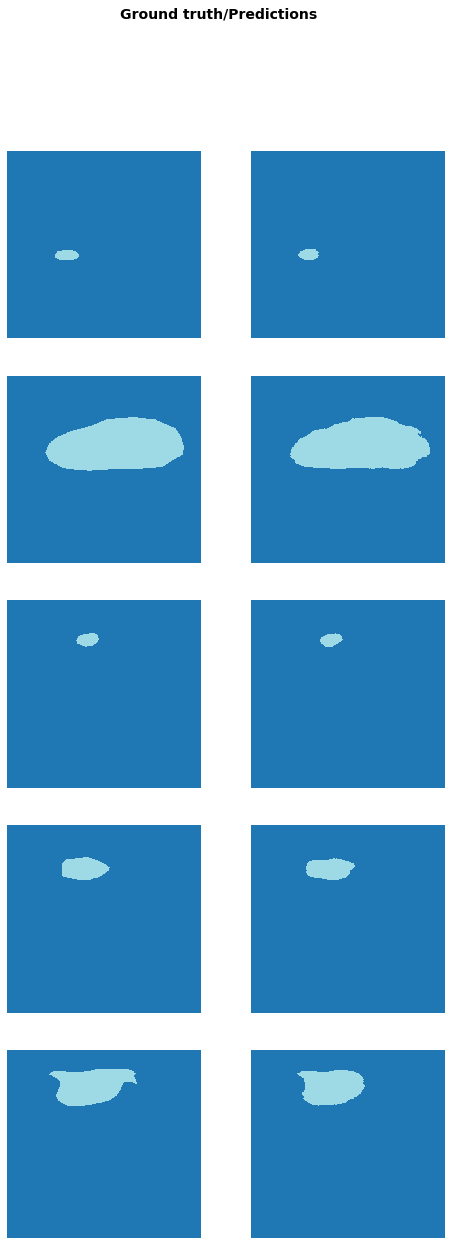

In [13]:
learn.show_results(alpha=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


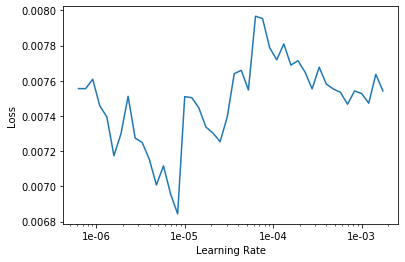

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(cyc_len = 100,max_lr = slice(1e-05, 1e-03))

epoch,train_loss,valid_loss,dice,time
0,0.007535,0.015146,0.907319,00:12
1,0.007713,0.014760,0.912583,00:13
2,0.007799,0.014638,0.914092,00:13
3,0.007869,0.014453,0.911349,00:13
4,0.007697,0.014574,0.914512,00:13
5,0.007555,0.015843,0.907551,00:13
6,0.007312,0.014562,0.912791,00:13
7,0.007197,0.016162,0.906201,00:13
8,0.007235,0.016281,0.899319,00:13
9,0.007271,0.014239,0.913384,00:13


In [16]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 233, 240]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 233, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 233, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 117, 120]       0          False     
______________________________________________________________________
Conv2d               [64, 117, 120]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 117, 120]       128        True      
______________________________________________________________________
ReLU                 [64, 117, 120]       0          False     
__________________________________________________

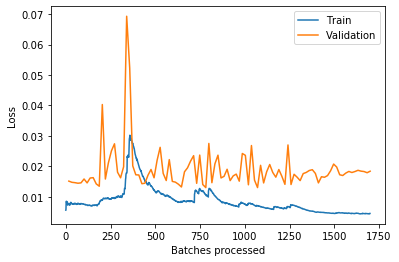

In [18]:
learn.recorder.plot_losses()

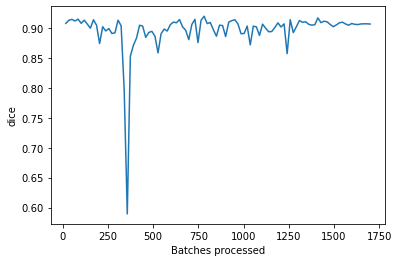

In [20]:
learn.recorder.plot_metrics()

In [17]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(cyc_len = 40,max_lr = slice(1e-05, 1e-03))

epoch,train_loss,valid_loss,dice,time
0,0.006292,0.017557,0.907396,00:13
1,0.005309,0.016630,0.911487,00:13
2,0.004965,0.018029,0.908624,00:13
3,0.004860,0.018752,0.902782,00:13
4,0.004705,0.018072,0.908563,00:13
5,0.004879,0.022999,0.898907,00:13
6,0.005092,0.078390,0.875574,00:13
7,0.015134,0.023771,0.904018,00:13
8,0.013033,0.017361,0.875163,00:13
9,0.011502,0.015715,0.909822,00:13


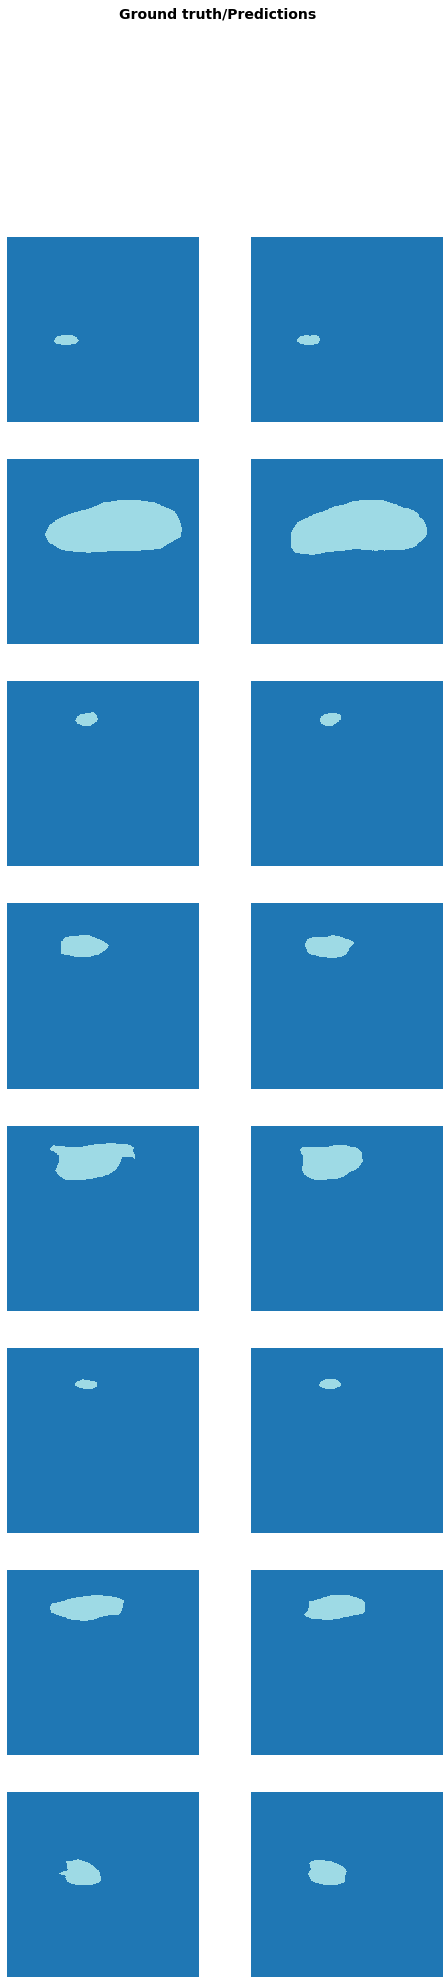

In [27]:
learn.show_results(rows=20,alpha=1)